In [1]:
%matplotlib inline
from fastai.basics import *

In [12]:
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

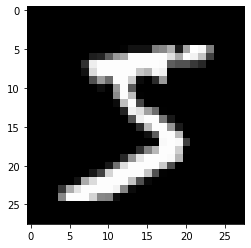

In [13]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [14]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [15]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [16]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [17]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [18]:
model = Mnist_Logistic().cuda()

In [19]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [20]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [21]:
model(x).shape

torch.Size([64, 10])

In [22]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [23]:
lr=2e-2

In [24]:
loss_func = nn.CrossEntropyLoss()

In [25]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [26]:
losses = [update(x,y,lr) for x,y in data.train_dl]

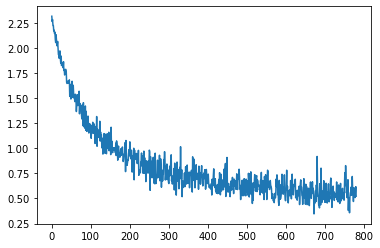

In [27]:
plt.plot(losses);

In [28]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [29]:
model = Mnist_NN().cuda()

In [30]:
losses = [update(x,y,lr) for x,y in data.train_dl]

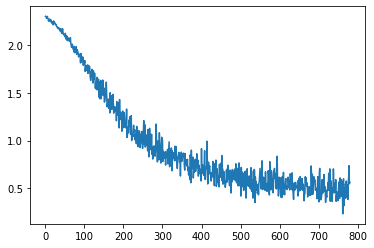

In [31]:
plt.plot(losses);

In [32]:

model = Mnist_NN().cuda()

In [33]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [34]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

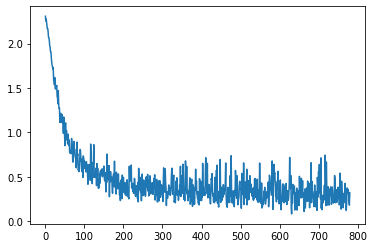

In [35]:
plt.plot(losses);

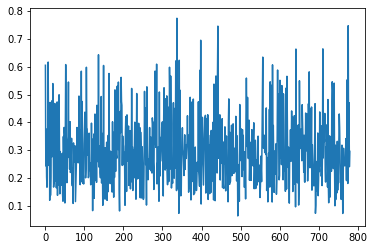

In [48]:
def update(x,y,lr):
    opt = optim.SGD(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

losses = [update(x,y,1e-3) for x,y in data.train_dl]
plt.plot(losses)

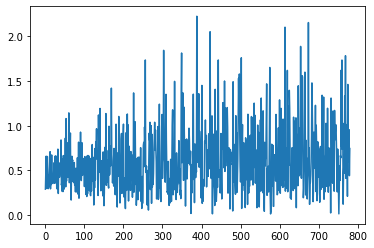

In [49]:
def update(x,y,lr):
    opt = optim.RMSprop(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

losses = [update(x,y,1e-3) for x,y in data.train_dl]
plt.plot(losses)

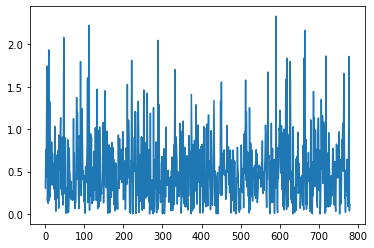

In [50]:
def update(x,y,lr):
    opt = optim.Adamax(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

losses = [update(x,y,1e-3) for x,y in data.train_dl]
plt.plot(losses)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdcb258d710>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/envs/fastai/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/envs/fastai/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/envs/fastai/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


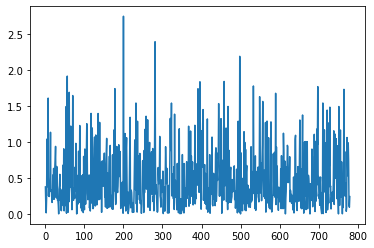

In [53]:
def update(x,y,lr):
    opt = optim.ASGD(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

losses = [update(x,y,1e-3) for x,y in data.train_dl]
plt.plot(losses)

In [36]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


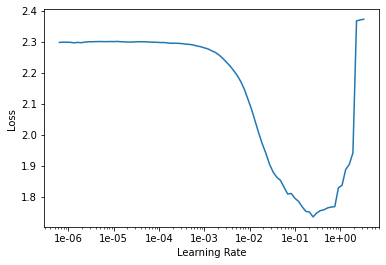

In [38]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(100, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.010743,0.099033,0.976700,00:03
1,0.010093,0.098461,0.976700,00:03
2,0.008907,0.101301,0.975400,00:03
3,0.009945,0.103423,0.976400,00:03
4,0.011469,0.107124,0.976000,00:03
5,0.008684,0.106969,0.975700,00:03
6,0.007605,0.108499,0.976500,00:03
7,0.010115,0.115272,0.975200,00:04
8,0.010563,0.115208,0.975600,00:04
9,0.016309,0.120236,0.976000,00:03


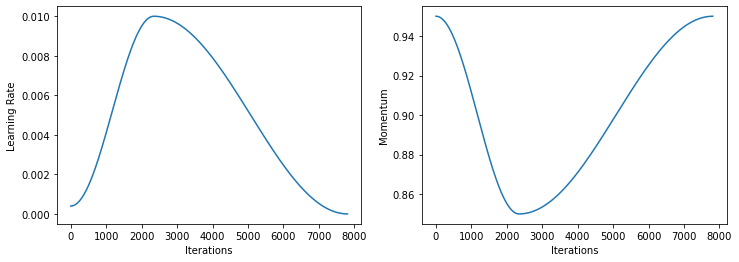

In [43]:
learn.recorder.plot_lr(show_moms=True)

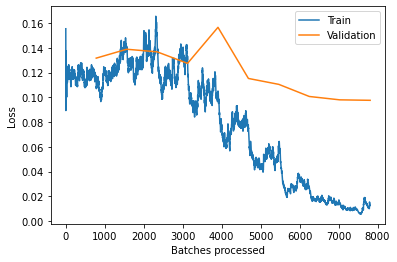

In [44]:
learn.recorder.plot_losses()

## fin

epoch,train_loss,valid_loss,accuracy,time
0,0.001116,0.179417,0.976600,00:03
1,0.032908,0.220711,0.969000,00:03
2,0.085252,0.190036,0.969300,00:03
3,0.088612,0.245203,0.963100,00:03
4,0.057778,0.155431,0.972200,00:03
5,0.047150,0.166531,0.971100,00:03
6,0.019595,0.139377,0.975800,00:03
7,0.004390,0.133613,0.976400,00:03
8,0.001617,0.120778,0.978200,00:03
9,0.000738,0.122638,0.978600,00:04


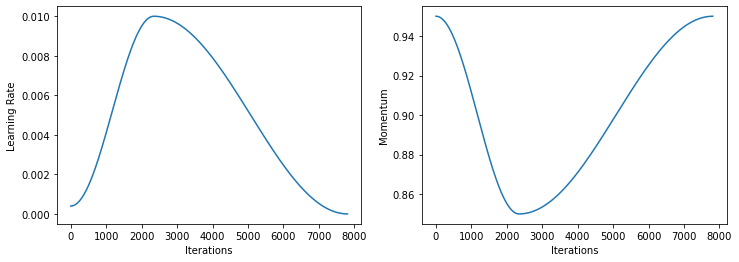

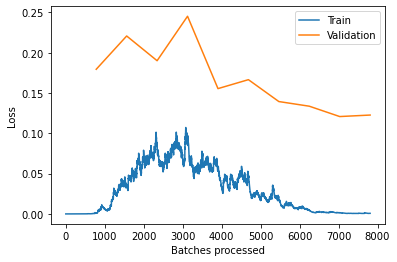

In [46]:
learn.fit_one_cycle(10, 1e-2)
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,0.014466,0.137881,0.976700,00:03


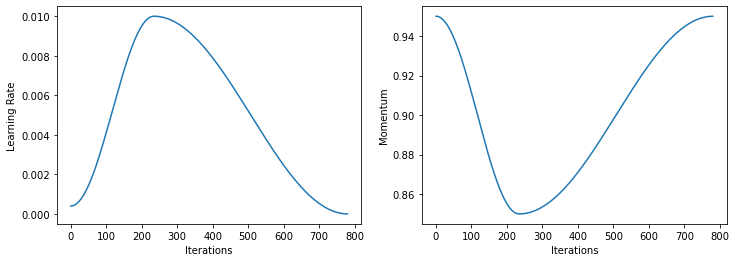

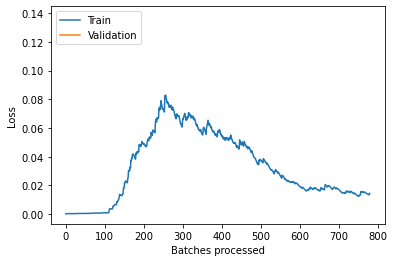

In [47]:
learn.fit_one_cycle(1, 1e-2)
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_losses()